The experiment is done with a random split so we should not detect a data drift

In [1]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

from cinnamon.drift import ModelDriftExplainer

# Boston Data

In [2]:
boston = datasets.load_boston()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

In [3]:
boston_df = pd.DataFrame(boston.data, columns = boston.feature_names)

In [4]:
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


# Build CatBoost model

In [5]:
X_train, X_test, y_train, y_test = train_test_split(boston_df, boston.target, test_size=0.3, random_state=2021)

In [6]:
model = CatBoostRegressor(loss_function='RMSE',
                         learning_rate=0.1,
                         iterations=1000,
                         max_depth=6,
                         early_stopping_rounds=20,
                         random_seed=2021,
                         verbose=10
                       )

In [7]:
model.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)])

0:	learn: 9.0250081	test: 7.5714674	best: 7.5714674 (0)	total: 87.9ms	remaining: 1m 27s
10:	learn: 5.5101725	test: 4.8483796	best: 4.8483796 (10)	total: 135ms	remaining: 12.1s
20:	learn: 3.8868563	test: 3.8740188	best: 3.8740188 (20)	total: 252ms	remaining: 11.7s
30:	learn: 3.0473190	test: 3.4650909	best: 3.4650909 (30)	total: 304ms	remaining: 9.5s
40:	learn: 2.6164783	test: 3.2959291	best: 3.2959291 (40)	total: 370ms	remaining: 8.65s
50:	learn: 2.2937618	test: 3.2353254	best: 3.2262441 (47)	total: 436ms	remaining: 8.11s
60:	learn: 2.0911178	test: 3.1815968	best: 3.1815968 (60)	total: 504ms	remaining: 7.76s
70:	learn: 1.9440377	test: 3.1566048	best: 3.1528590 (67)	total: 593ms	remaining: 7.76s
80:	learn: 1.8096161	test: 3.1425519	best: 3.1425519 (80)	total: 672ms	remaining: 7.62s
90:	learn: 1.6906960	test: 3.1297230	best: 3.1215636 (87)	total: 759ms	remaining: 7.58s
100:	learn: 1.5982758	test: 3.1191340	best: 3.1148342 (98)	total: 866ms	remaining: 7.71s
110:	learn: 1.5115901	test: 3.11

# Analyze data drift with ModelDriftExplainer

In [8]:
drift_explainer = ModelDriftExplainer(model)
drift_explainer.fit(X1=X_train, X2=X_test, y1=y_train, y2=y_test)

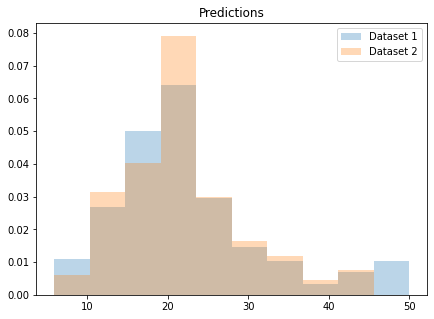

[DriftMetricsNum(mean_difference=-0.8779339801393569, wasserstein=1.250335807497859, ks_test=BaseStatisticalTestResult(statistic=0.05764942016057092, pvalue=0.8464257838033303))]

In [9]:
drift_explainer.plot_prediction_drift()
drift_explainer.get_prediction_drift()

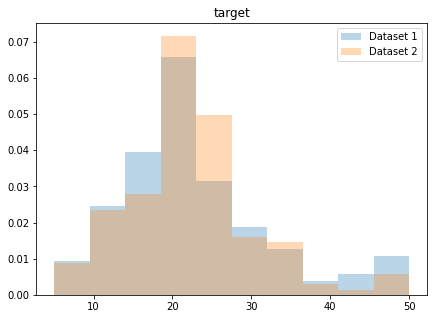

DriftMetricsNum(mean_difference=-0.609240261671129, wasserstein=1.3178114778471604, ks_test=BaseStatisticalTestResult(statistic=0.07857567647933393, pvalue=0.49680300786363996))

In [10]:
drift_explainer.plot_target_drift()
drift_explainer.get_target_drift()

In [11]:
drift_explainer.get_performance_metrics_drift()

PerformanceMetricsDrift(dataset1=RegressionMetrics(mse=1.9584429193171917, explained_variance=0.9788618728948271), dataset2=RegressionMetrics(mse=9.57426222359859, explained_variance=0.8537685044683866))

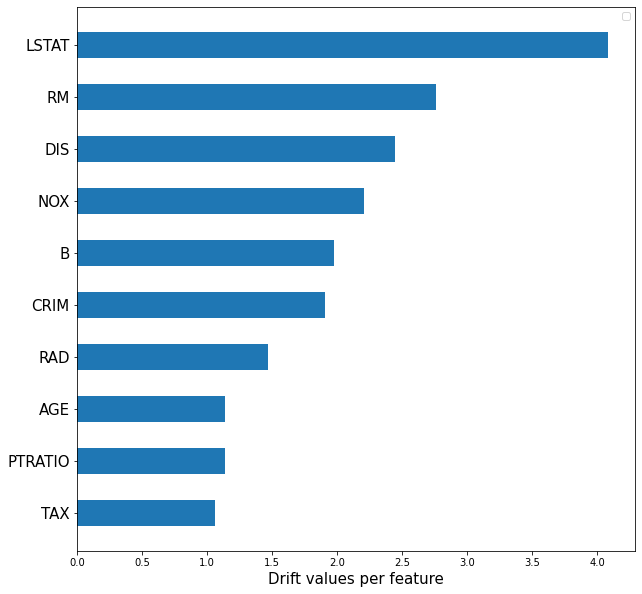

In [12]:
drift_explainer.plot_tree_based_drift_values(type='node_size')

In [13]:
drift_explainer.get_tree_based_drift_values(type='mean')

array([[ 0.06869412],
       [-0.00890033],
       [ 0.00371266],
       [ 0.04273852],
       [ 0.09479128],
       [-0.34271389],
       [-0.04711113],
       [-0.03455269],
       [-0.09711201],
       [-0.0245336 ],
       [-0.07489948],
       [-0.09540242],
       [-0.362645  ]])

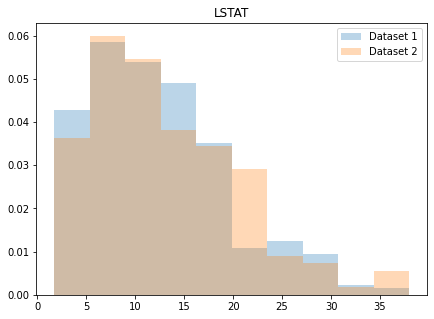

DriftMetricsNum(mean_difference=0.7378638864109419, wasserstein=0.8023078352661315, ks_test=BaseStatisticalTestResult(statistic=0.08887154326494201, pvalue=0.3452770147763935))

In [14]:
drift_explainer.plot_feature_drift('LSTAT')
drift_explainer.get_feature_drift('LSTAT')